In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import mglearn
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

%matplotlib inline

# 教師なし学習と前処理
教師なし学習は、元のデータ表現を変換して人間や他の機械学習にとってよりわかりやすい新しいデータ表現を作る。教師なし学習はモデルが上手くいってるのか判断しにくい難しさがあるが、これらは分析者がデータを理解するために探索的に用いたり、教師あり学習の前処理として使える。

* スケーリング:  
  値を0～1の間や、平均0分散1へ変換。スケールに敏感な学習器を使用する際に使用
* 次元削減・成分抽出:  
  高次元表現を入力に少数の本質的な特徴を示す特徴量で表す要約方法へ変換
* クラスタリング:  
  データを似たような要素から構成されるグループへ分割

# スケーリング
SVN、NNは入力データのスケールに敏感だが、これらのスケールの変換には次のようなクラスが提供されている。使用する際には訓練データで **fit()** し、**transform()** で変換する (まとめて行うfit_transform()もある)。

* StandardScaler: 平均0分散1に変換
* RobustScaler: 平均値・分散の代わりに中央値・四分位数を使う。外れ値に強い
* MinMaxScaler: 0～1の間に変換
* Normalizer: 個々のベクトルのユーグリッド長が1になるよう変換 (データポイントを半径1の円に投射)

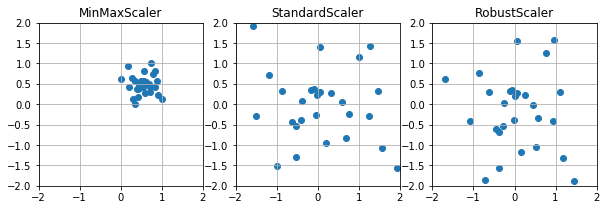

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

# 平均0標準偏差3の正規分布
np.random.seed(0)
dt = np.random.randn(30, 2) * 3

# それぞれ試す
# MinMaxScaler, StandardScaler, RobustScaler
plt.figure(figsize=(10, 3))
for i, s in enumerate([MinMaxScaler(), StandardScaler(), RobustScaler()]):
    plt.subplot(1, 3, i + 1)
    plt.scatter(*s.fit_transform(dt).T)
    plt.title(type(s).__name__)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    plt.grid()


# 次元削減・成分抽出
## 主成分分析 (PCA)
データセットを重み係数を掛けた和に変換する。

$$
    {\bf x}^\prime = {\bf x}{\boldsymbol A}
$$

重み係数はデータセットを各特徴量に相関関係が生じないよう回転させる作用を持つ。回転後の新たな軸は **主成分ベクトル** と呼ばれるが、これは計算式での重み係数 (pca.component_) そのものでもある。そのまま教師あり学習にまわす他、高次元データの解釈において重要な特徴量だけを抜き出して (**次元削減**) 可視化する使い方もされる。

以下では乳癌のデータセット(30次元)を2次元に削減し散布図にプロットしてる。そのままでは可視化不能な次元数のデータをうまくプロットしており、また次元削減による情報欠落も診断結果が単純な線形回帰で解けそうな分布に収まっていることが分かる。

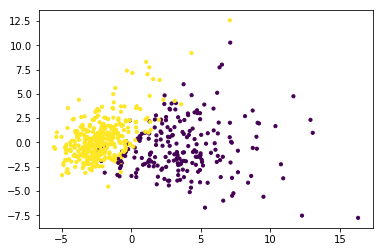

In [3]:
from sklearn.decomposition import PCA
cancer = datasets.load_breast_cancer()

# スケール調整
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cancer.data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 主成分2つ分で上手く別れている
plt.scatter(*X_pca.T, s=10, c=cancer.target)

主成分を可視化。成分はcomponent_に格納されており、列ごとに元特徴量からの貢献度が入る。
今回の場合、主成分0番は元特徴量全てが正の数値になっており、全てに相関関係がある事を示す。

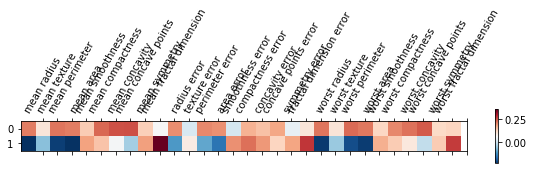

In [4]:
plt.figure(figsize=(10, 1))
plt.matshow(pca.components_, fignum=False, cmap="RdBu_r")
plt.xticks(np.arange(30) + 1, cancer.feature_names, rotation=60)
plt.colorbar()

参考
* http://www.geisya.or.jp/~mwm48961/statistics/syuseibun1.htm
* https://qiita.com/NoriakiOshita/items/460247bb57c22973a5f0

顔画像へPCAを使ってみる。サンプルは人物毎の数に偏りがあるため、1人50枚で統一する。

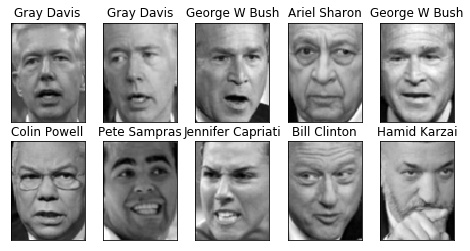

In [5]:
# Labelled Faces in the Wild (LFW) Dataset
people = datasets.fetch_lfw_people(min_faces_per_person=20, resize=0.7)

plt.figure(figsize=(8, 4))
for i, (target, image) in enumerate(zip(people.target[:10], people.images[:10])):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap="gray")
    plt.xticks(())
    plt.yticks(())
    plt.title(people.target_names[target])

In [6]:
# 複数の顔を50枚ずつ確保
mask = np.zeros_like(people.target, dtype=np.bool)
for i in range(people.target_names.size):
    mask[np.where(people.target == i)[0][:50]] = 1

X_people = people.data[mask] / 255
y_people = people.target[mask]
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

学習された重みを可視化する。

In [7]:
from sklearn.decomposition import PCA

# データの次元を5655 -> 100へ削減
k = 100
pca = PCA(n_components=k, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

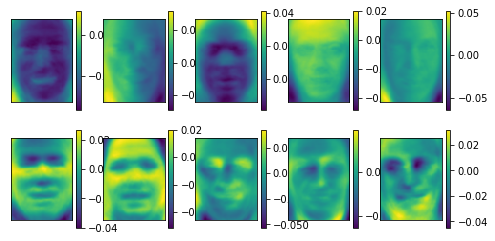

In [8]:
s = people.images[0].shape
plt.figure(figsize=(8, 4))
for i, comp_img in enumerate(pca.components_.reshape(k, *s)[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(comp_img)
    plt.colorbar()
    plt.xticks(())
    plt.yticks(())

処理後のデータを元に戻すには主成分ベクトルを掛けてやれば良い他、inverse_transform()も使用可能。次元削減が行われているため、画像は情報欠落によってぼやけた仕上がりになる。

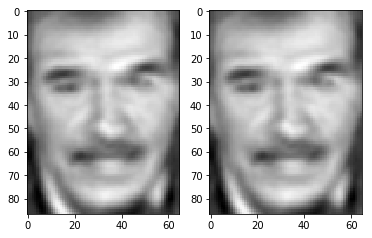

In [9]:
# 自力復元
im = X_train_pca[0] @ pca.components_ + pca.mean_
plt.subplot(1, 2, 1)
plt.imshow(im.reshape(s), cmap="gray")

# 逆回転関数使用
im = pca.inverse_transform(X_train_pca[0])
plt.subplot(1, 2, 2)
plt.imshow(im.reshape(s), cmap="gray")

固有値、固有ベクトルのメモ

In [10]:
# 値を用意
mtr = np.arange(4).reshape(2, 2)

# 固有値[n], 固有ベクトル[i,n]
lam, w = np.linalg.eig(mtr)
lam = lam[np.newaxis,:]

# 値が一致する (Aw = λw)
print(mtr @ w)
print(lam * w)

[[ 0.48963374 -0.96276969]
 [-0.2749552  -3.42895508]]
[[ 0.48963374 -0.96276969]
 [-0.2749552  -3.42895508]]


## 非負行列因子分解 (NMF)
NMFも次元削減に使用可能。NMFは入力行列をN個の基底行列と係数行列の内積で表現する。入力は非負行列に制約されるが、PCAの成分は負の数値もあるため解釈が難しいのに対してNMFは因子分解後の行列も非負行列となり解釈しやすい。これらの成分は複数の基底ベクトルの和でデータポイントを表現しており、基底ベクトルは十分な数がある場合には極端な方向へ、足りない場合には平均的な方向を向く動きをする。なお、基底ベクトルと変換後データの形はPCAと同じになる。

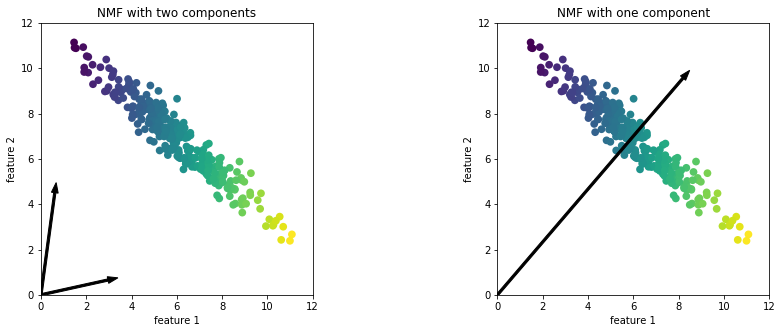

In [11]:
mglearn.plots.plot_nmf_illustration()

先程の顔画像をNMFにかける。各画像には訓練画像から顔の部分的特徴が抽出される。試しに基底ベクトルの可視化と特定の基底ベクトルの成分の強い画像を列挙する。

In [12]:
from sklearn.decomposition import NMF

k = 15
nmf = NMF(n_components=k, random_state=0).fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

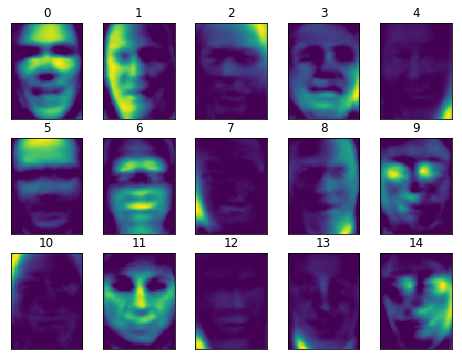

In [13]:
s = people.images[0].shape
plt.figure(figsize=(8, 6))
for i, comp_img in enumerate(nmf.components_.reshape(k, *s)[:k]):
    plt.subplot(3, 5, i + 1)
    plt.imshow(comp_img)
    plt.title(i)
    plt.xticks(())
    plt.yticks(())

14, 9番目の基底ベクトルの成分が強い画像を列挙する。左向きの顔の特徴に対して強い反応がある画像は左を向いていおり、右向きの特徴では右向きの顔に強い反応がある。負の特徴量が無いため、PCAよりも基底ベクトルの解釈がしやすい。

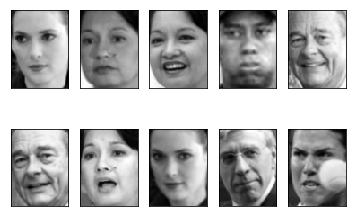

In [14]:
# 14番目の基底ベクトル
idxs = np.argsort(X_train_nmf[:,14])[-10:]
for i, img in enumerate(X_train[idxs]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.reshape(s), cmap="gray")
    plt.xticks(())
    plt.yticks(())

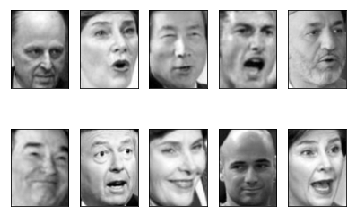

In [15]:
# 9番目の基底ベクトル
idxs = np.argsort(X_train_nmf[:,9])[-10:]
for i, img in enumerate(X_train[idxs]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.reshape(s), cmap="gray")
    plt.xticks(())
    plt.yticks(())

## t-SNEを用いた多様体学習
高次元データの可視化ではまずPCAを試すのは悪くないが、軸に対して正規分布の仮定があり非線形との相性が悪いなど有用性は限られる。可視化には **多様体学習アルゴリズム** がよく用いられ、遥かに複雑なマッピングを行い、より良い可視化を実現できる。これらは主に可視化に使用されるため、3以上の新しい特徴量を生成させることはない。また一部のアルゴリズムは訓練データを変換できるが、新しいデータの変換はできない。よって、教師あり学習用の前処理よりも探索的なデータ解析に用いられる。

特に有用なアルゴリズムとして **t-SNE アルゴリズム** がある。このアルゴリズムは、データポイントの距離を可能な限り維持する2次元表現を見つけようとする。ここでは手書き数字へ適用してみる。

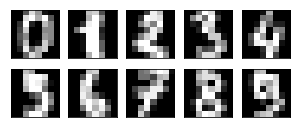

In [16]:
digits = datasets.load_digits()

plt.figure(figsize=(5, 2))
for i, img in enumerate(digits.images[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap="gray")
    plt.xticks(())
    plt.yticks(())

In [17]:
from sklearn.manifold import TSNE

digits_pca = PCA(n_components=2).fit_transform(digits.data)
digits_tsne = TSNE(random_state=42).fit_transform(digits.data)

教師なし学習であるにも関わらず、クラスが明確に分類される。t-SNEにはハイパーパラメータが幾つかあるが、デフォルト設定で大抵はうまく機能する。perplexity, early_exaggeration などの設定があるが、一般に効果は大きくない。

Text(0.5, 1.0, 't-SNE')

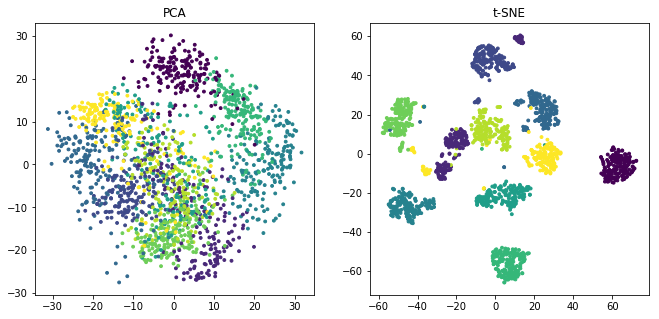

In [18]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.scatter(*digits_pca.T, s=8, c=digits.target)
plt.title("PCA")

plt.subplot(1, 2, 2)
plt.scatter(*digits_tsne.T, s=8, c=digits.target)
plt.title("t-SNE")

# クラスタリング
## k-means
最も単純で広く用いられているクラスタリングアルゴリズム。データのある領域を代表するようなクラスタ重心を見つけようとする。推論はデータポイントと各重心の距離から最も最短のクラスタを選ぶ。ちなみにデータポイントをどのクラスタに属するかを求めることは、データポイントをクラスタ番号 (単一成分) で表現しているとも見なせる。これは **ベクトル量子化** と呼ぶ。

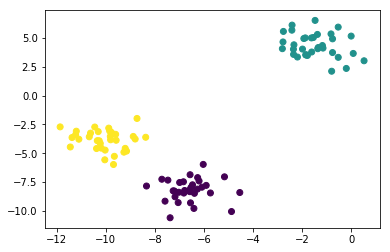

In [39]:
from sklearn.cluster import KMeans

X, y = datasets.make_blobs(random_state=1)
y_pred = KMeans(n_clusters=3).fit_predict(X)

plt.scatter(*X.T, c=y_pred)

k-meansの制約として、クラスタ数の指定が必要になるほか、単純な形状にしか対応できない。

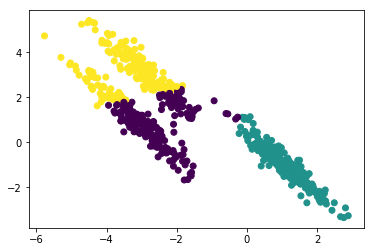

In [59]:
X, y = datasets.make_blobs(random_state=170, n_samples=600)
X = X @ np.random.RandomState(74).normal(size=(2, 2))

y_pred = KMeans(n_clusters=3).fit_predict(X)
plt.scatter(*X.T, c=y_pred)

k-meansのクラスタ中心点もPCAの基底ベクトルと同じく、画像に適用すると画像の特徴を抽出した処理結果になる。ただ、k-meansは入力次元よりも大きなクラスタを扱える点が他と異なる。

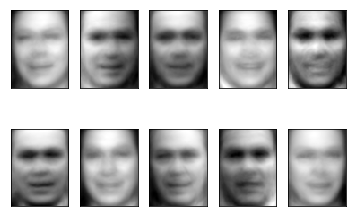

In [36]:
kmeans = KMeans(n_clusters=10).fit(X_train)
X_train_kmeans = kmeans.cluster_centers_
X_train_kmeans.shape

idxs = np.argsort(X_train_nmf[:,9])[-10:]
for i, img in enumerate(X_train_kmeans):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.reshape(s), cmap="gray")
    plt.xticks(())
    plt.yticks(())

## 凝集型クラスタリング
個別のクラスタとして開始し、最も類似した2つのクラスタを併合。 これを一定条件を満たすまで繰り返す **凝集型クラスタリング** と呼ばれるアルゴリズムがある。scikit-learnでは一定クラスタ数に減るまで続ける種類のものが使用可能。クラスタ類似度の計測方法として次の3つが定義されているが、大抵はwardでうまく機能する (クラスタ間でデータポイントの数が極端に違う場合には他の方が良いかもしれない)。なお、凝集型クラスタリングは未知のデータのクラスタを調べることはできない。

* ward (既定):  
  併合した際にクラスタ内の分散の増分が最小になるよう2つのクラスタを選択。多くの場合、比較的に同サイズのクラスタになる。
* average:  
  クラスタ間の全てのポイント間の平均距離が最小の2クラスタを併合
* complete:  
  2クラスタの点間の距離の最大値が最小となるものを併合

このアルゴリズムは階層型クラスタリングの一種とされており、クラスタ併合を記録するとデータポイントは全データポイントを保持する1クラスタを頂点に複数階層から成るツリー構造が浮かび上がる。このツリー構造はデータのクラスタ数を決める上で参考になる。ツリー構造は **デンドログラム** という可視化がある。この可視化ではツリー構造からクラスタ併合の流れを見ることができるほか、枝の長さで併合前のクラスタ間の距離が出る。

Text(122.0, 4.0, 'three clusters')

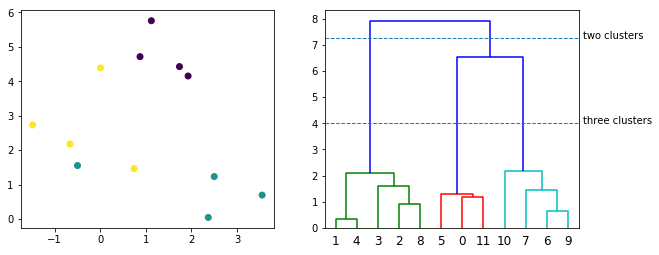

In [122]:
# SciPyからデンドログラム関数とwardクラスタリング関数をインポート
from scipy.cluster.hierarchy import dendrogram, ward

X, y = datasets.make_blobs(random_state=0, n_samples=12)
# wardクラスタリングをデータ配列Xに適用
# SciPyのward関数は、凝集型クラスタリングを行った際のブリッジ距離を示す配列を返す
linkage_array = ward(X)

# 生成データを散布図としてプロット
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(*X.T, c=y)

# linkage_arrayに書かれたクラスタ間距離をデンドログラムとしてプロット
ax = plt.subplot(1, 2, 2)
dendrogram(linkage_array)

# 2,3クラスタの部分での切断を表示
bounds = ax.get_xbound()
ax.axhline(7.25, ls="--", lw=1)
ax.axhline(4.00, ls="--", lw=1)
ax.text(bounds[1] + 2, 7.25, "two clusters")
ax.text(bounds[1] + 2, 4.00, "three clusters")

残念ながら凝集型クラスタリングでも上手く扱えないデータはある。

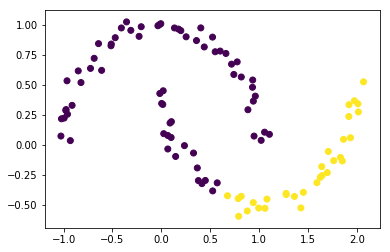

In [60]:
from sklearn.cluster import AgglomerativeClustering

X, y = datasets.make_moons(noise=0.05)
y_pred = AgglomerativeClustering(n_clusters=2).fit_predict(X)
plt.scatter(*X.T, c=y_pred)

## DBSCAN
このアルゴリズムはクラスタがデータ中で高密度領域を構成しており、比較的空虚な空間で区切られている仮定に基づいている。ハイパーパラメータとしてmin_sampleとepsが用いられ、処理後にはデータポイントは3つに分類される。各クラスタはコアサンプルと境界ポイントから成る。

* コアサンプル: 距離eps以内にmin_sample個以上の点がデータポイント
* 境界ポイント: コアサンプルの条件を満たすだけの近傍点がないデータポイント
* ノイズ: 近傍点がないデータポイント

クラスタリングは以下のように行われる。

1. 未処理データを1つ取得
    - コアサンプル条件を満たせば新クラスタラベルを付与
    - 満たさなければノイズとマーク
2. 近傍点抽出を繰り返す
    - コアサンプルと同クラスタラベルを付与
    - コアサンプル条件を満たせばコアサンプル、満たさなければ境界ポイントとマーク
3. 近傍点が無くなれば1に戻る

### 特徴
もう一つの非常に有用なクラスタリングアルゴリズムとしてDBSCANがある。このアルゴリズムにはクラスタ数を事前に与える必要が無い事と、どのクラスタにも属さない点を判別できる特徴がある。また、処理速度は凝集型クラスタリングやk-meansよりも遅いが、比較的大きいデータへも適用可能。注意点として結果に-1 (ノイズ) が含まれるため、結果を別の配列のインデックスに用いるなどに気を付ける必要がある。

### パラメータ
* min_sample: コアサンプルとするための近傍点の数
* eps: 近接点とする距離

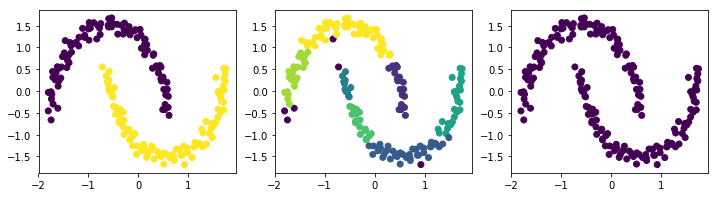

In [139]:
from sklearn.cluster import DBSCAN
X, y = datasets.make_moons(n_samples=200, noise=0.05, random_state=0)
X_scaled = StandardScaler().fit_transform(X)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
y_pred = DBSCAN().fit_predict(X_scaled)
plt.scatter(*X_scaled.T, c=y_pred)

plt.subplot(1, 3, 2)
y_pred = DBSCAN(eps=0.2).fit_predict(X_scaled)
plt.scatter(*X_scaled.T, c=y_pred)

plt.subplot(1, 3, 3)
y_pred = DBSCAN(eps=0.7).fit_predict(X_scaled)
plt.scatter(*X_scaled.T, c=y_pred)

## クラスタリング手法まとめ
アルゴリズムにはそれぞれ異なる長所がある。

* k-means: クラスタセンタを用いてクラスタの特徴を表現できる
* 凝集型クラスタリング: データの階層的な分割候補を提示できる。デンドログラムで可視化できる
* DBSCAN: どのクラスタにも属さない「ノイズ」を検出可能。複雑な形状のクラスタに対応する